# DRED Dataset EDA and Preprocessing

## EDA

Let's perform some EDA to get an idea of this dataset.

In [ ]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [ ]:
#TODO: change this back to normal files
dataset_folder = "/content/drive/MyDrive/dred/"
output_folder = "/content/drive/MyDrive/dred/"
dred_file = "DRED_Aggregated_data.csv"
dred_appliance_file = "DRED_Appliance_data.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Appliance

In [ ]:
df_app_orig = pd.read_csv(dataset_folder + dred_appliance_file, skiprows = 1)
df_app_orig['timestamp'] = df_app_orig['Unnamed: 0'].str.slice(stop=-6)
df_app_orig['timestamp'] = pd.to_datetime(df_app_orig['timestamp'], format="%Y/%m/%d %H:%M:%S")
df_app_orig = df_app_orig.drop(columns=['Unnamed: 0'])

In [ ]:
df_app_orig.columns

Index(['television', 'fan', 'fridge', 'laptop computer',
       'electric heating element', 'oven', 'unknown', 'washing machine',
       'microwave', 'toaster', 'sockets', 'cooker', 'timestamp'],
      dtype='object')

In [ ]:
target_column = 'microwave'

In [ ]:
df_app = df_app_orig

In [ ]:
train_range = pd.date_range(start = '2015-07-05', end = '2015-08-08', freq = '1D')
test_range = pd.date_range(start = '2015-08-09', end = '2015-08-18', freq = '1D')
total_range_1 = pd.date_range(start = '2015-09-01', end = '2015-09-30', freq = '1D')
total_range_2 = pd.date_range(start = '2015-07-05', end = '2015-08-18', freq = '1D')
df_app['date']= df_app.timestamp.dt.normalize()

df_app1 = df_app[df_app.date.isin(total_range_1)]
df_app2 = df_app[df_app.date.isin(total_range_2)]

In [ ]:
df_app1 = df_app1[[target_column, 'date', 'timestamp']]
df_app2 = df_app2[[target_column, 'date', 'timestamp']]

In [ ]:
df_app1 = df_app1.set_index('timestamp').resample('1s', origin='start').asfreq().reset_index()
df_app2 = df_app2.set_index('timestamp').resample('1s', origin='start').asfreq().reset_index()

In [ ]:
df_app = pd.concat([df_app1, df_app2])

In [ ]:
df_app.microwave.value_counts().iloc[:50]

1.24       5678819
0.98        505102
1.51        172910
25.23        37157
2.04          8783
19.90         3577
25.77         2763
19.37         2337
25.50         1997
26.03         1947
20.17         1621
2.31          1386
19.64         1326
19.63         1075
19.10         1015
25.76          847
20.43          609
43.62          592
43.89          558
44.69          542
44.16          212
18.84          210
43.36          196
44.42          190
64.68          176
43.09          148
64.41          144
20.44          142
38.29          113
1.78           100
42.82           97
64.14           81
44.96           79
44.95           65
1423.85         53
64.94           49
1425.97         38
1440.89         36
1428.64         35
1378.60         35
1421.43         34
1437.92         34
1442.75         33
1429.97         33
1384.96         32
1383.13         32
1416.39         31
1439.00         24
1420.65         21
1420.89         21
Name: microwave, dtype: int64

In [ ]:
df_app.isna().sum()

timestamp     0
microwave    22
date          0
dtype: int64

In [ ]:
# Fill nas
df_app[target_column][df_app[target_column].isna()] = 1.24

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


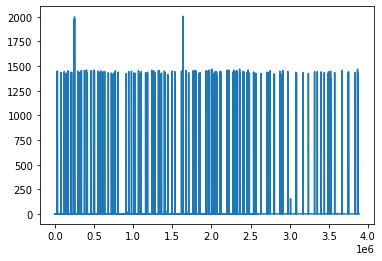

In [ ]:
df_app[target_column].plot()

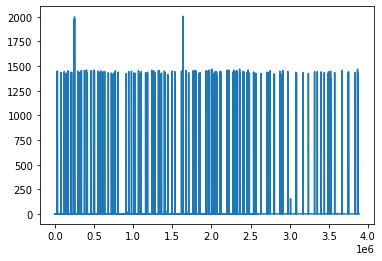

In [ ]:
df_app[target_column].plot()

Microwave is generally over 1000 watts. We use that to determine target column.

Let's directly just use $60 \times 60$ blocks of CNN.

In [ ]:
df_app = df_app.set_index('timestamp')

In [ ]:
df_app

,microwave,date
timestamp,,
2015-09-01 00:00:00,1.24,2015-09-01
2015-09-01 00:00:01,1.24,2015-09-01
2015-09-01 00:00:02,1.24,2015-09-01
2015-09-01 00:00:03,1.24,2015-09-01
2015-09-01 00:00:04,1.24,2015-09-01
...,...,...
2015-08-18 23:59:55,1.24,2015-08-18
2015-08-18 23:59:56,1.24,2015-08-18
2015-08-18 23:59:57,1.24,2015-08-18


In [ ]:
microwave_counts_ = df_app.resample('3600S', origin='start').apply(lambda x: sum(x['microwave'] > 1000)) 

In [ ]:
microwave_counts_[microwave_counts_ > 10] # more than 10 seconds of microwave being on

timestamp
2015-07-05 08:00:00     58
2015-07-05 21:00:00     23
2015-07-05 22:00:00     64
2015-07-06 08:00:00    110
2015-07-06 10:00:00     57
                      ... 
2015-09-27 21:00:00     18
2015-09-28 07:00:00    126
2015-09-28 08:00:00     36
2015-09-29 13:00:00     16
2015-09-30 09:00:00     45
Length: 170, dtype: int64

In [ ]:
target = torch.tensor(np.where(microwave_counts_>= 10, 1, 0))

### Time to Get Actual Dataset

In [ ]:
df_dred = pd.read_csv(dataset_folder + dred_file)
df_dred = df_dred[2:]
df_dred.columns = ['timestamp', 'Mains']
df_dred.timestamp = df_dred.timestamp.str.slice(stop=-6)
df_dred['timestamp'] = pd.to_datetime(df_dred['timestamp'], format="%Y/%m/%d %H:%M:%S")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_dred = df_dred.set_index('timestamp').resample('1s', origin='start').asfreq().reset_index()

In [ ]:
df_dred['date']= df_dred.timestamp.dt.normalize()
df_dred = df_dred[df_dred.date.isin(total_range_1) | df_dred.date.isin(total_range_2)]

In [ ]:
df_dred['kwh'] = pd.to_numeric(df_dred.Mains) / 1000
df_dred = df_dred.drop(columns='Mains')

In [ ]:
df_dred

,timestamp,date,kwh
0,2015-07-05 00:00:00,2015-07-05,NaN
1,2015-07-05 00:00:01,2015-07-05,NaN
2,2015-07-05 00:00:02,2015-07-05,NaN
3,2015-07-05 00:00:03,2015-07-05,NaN
4,2015-07-05 00:00:04,2015-07-05,NaN
...,...,...,...
7603195,2015-09-30 23:59:55,2015-09-30,0.1244
7603196,2015-09-30 23:59:56,2015-09-30,0.1247
7603197,2015-09-30 23:59:57,2015-09-30,0.1250
7603198,2015-09-30 23:59:58,2015-09-30,0.1251


In [ ]:
minmax_error_checker = df_dred.set_index('timestamp').resample('60T').apply(lambda x: len(x.kwh.unique()) == 1)
minmax_error_checker[minmax_error_checker == True]

Series([], Freq: 60T, dtype: bool)

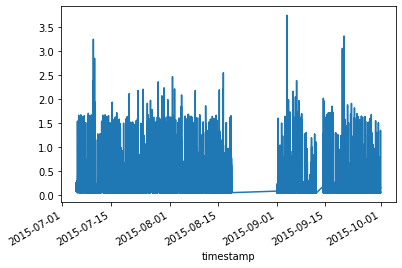

In [ ]:
df_dred.set_index('timestamp').kwh.plot()

In [ ]:
df_dred.loc[df_dred.kwh.isna(), 'kwh'] = df_dred.kwh.mode().values[0] # set kwh to mode

In [ ]:
df_dred_tensor = torch.tensor(df_dred.kwh.to_numpy())
df_dred_tensor = df_dred_tensor.reshape(-1, 60, 60)

In [ ]:
df_dred_tensor.shape

torch.Size([1800, 60, 60])

Remember to **normalize**

In [ ]:
min_meter = torch.amin(df_dred_tensor, dim = (1, 2), keepdim=True)
max_meter = torch.amax(df_dred_tensor, dim = (1, 2), keepdim=True)
df_dred_tensor = (df_dred_tensor - min_meter) / (max_meter - min_meter)

In [ ]:
df_dred_tensor.isnan().sum()

tensor(0)

## CREATE COMBINED TENSORS

In [ ]:
test_index = np.random.choice(df_dred_tensor.shape[0], int(df_dred_tensor.shape[0]*.25), replace=False)
train_index = np.setdiff1d(np.arange(df_dred_tensor.shape[0]), test_index)

In [ ]:
train_index

array([   0,    1,    2, ..., 1796, 1797, 1799])

In [ ]:
target[train_index].sum()

tensor(107)

In [ ]:
target[test_index].sum()

tensor(39)

In [ ]:
train_combined = [df_dred_tensor[train_index], target[train_index]]
test_combined = [df_dred_tensor[test_index], target[test_index]]

In [ ]:
torch.save(train_combined, output_folder + 'dred_model_train.pt')
torch.save(test_combined, output_folder + 'dred_model_test.pt')